In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import _tree
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import Counter

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
feature_names = data.feature_names

# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, y)

# Function to extract rules from a decision tree
def extract_rules(tree, feature_names):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    rules = []

    def recurse(node, current_rule):
        if tree_.children_left[node] == _tree.TREE_LEAF:
            rule_str = " AND ".join(current_rule)
            rules.append(rule_str)
        else:
            rule_left = f"({feature_names[feature[node]]} <= {threshold[node]:.2f})"
            current_rule.append(rule_left)
            recurse(tree_.children_left[node], current_rule)
            current_rule.pop()

            rule_right = f"({feature_names[feature[node]]} > {threshold[node]:.2f})"
            current_rule.append(rule_right)
            recurse(tree_.children_right[node], current_rule)
            current_rule.pop()

    recurse(0, [])
    return rules

# Extract rules from all trees in the Random Forest
tree_rules = [extract_rules(est, feature_names) for est in rf.estimators_]

# Flatten rules and store tree association
all_rules = []
tree_indices = []
for i, rules in enumerate(tree_rules):
    for rule in rules:
        all_rules.append(rule)
        tree_indices.append(i)

# Label encoding for feature names
feature_encoder = LabelEncoder()
feature_encoder.fit(feature_names)

def encode_rule(rule):
    encoded_rule = []
    for condition in rule.split(" AND "):
        if "<=" in condition:
            feature_name, threshold = condition.strip("()").split(" <= ")
            feature_name = feature_name.strip()
            encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_LTE_{threshold}")
        elif ">" in condition:
            feature_name, threshold = condition.strip("()").split(" > ")
            feature_name = feature_name.strip()
            encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_GT_{threshold}")
    return " AND ".join(encoded_rule)

encoded_rules = [encode_rule(rule) for rule in all_rules]

# TF-IDF Vectorization of Encoded Rules
vectorizer = TfidfVectorizer()
rule_vectors = vectorizer.fit_transform(encoded_rules)

# Agglomerative Clustering
n_clusters = 5 # Define number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
rule_clusters = clustering.fit_predict(rule_vectors.toarray())

# Create DataFrame to store clustered rules
rule_df = pd.DataFrame({"Rule": all_rules, "Encoded Rule": encoded_rules, "Tree Index": tree_indices, "Cluster": rule_clusters})

# Function to get the most representative rule per cluster
def summarize_cluster_rules(df):
    summarized_rules = {}
    for cluster in df["Cluster"].unique():
        cluster_rules = df[df["Cluster"] == cluster]["Rule"].values
        most_common_rule = Counter(cluster_rules).most_common(1)[0][0]
        summarized_rules[cluster] = most_common_rule
    return summarized_rules

# Summarized rules for each cluster
summarized_rules = summarize_cluster_rules(rule_df)

# Assign global rule to each tree (most frequent rule in each tree)
tree_global_rules = {}
for tree_index in range(len(tree_rules)):
    tree_cluster_rules = rule_df[rule_df["Tree Index"] == tree_index]["Cluster"].values
    if len(tree_cluster_rules) > 0:
        most_common_cluster = Counter(tree_cluster_rules).most_common(1)[0][0]
        tree_global_rules[tree_index] = summarized_rules[most_common_cluster]

# Classify instances using tree global rules
def classify_with_summarized_rules(instance, tree_global_rules):
    votes = []
    rule_contributions = {}

    for tree_idx, rule in tree_global_rules.items():
        satisfied = True
        for condition in rule.split(" AND "):
            if "<=" in condition:
                feature_name, threshold = condition.strip("()").split(" <= ")
                threshold = float(threshold)
                if instance[feature_name] > threshold:
                    satisfied = False
                    break
            elif ">" in condition:
                feature_name, threshold = condition.strip("()").split(" > ")
                threshold = float(threshold)
                if instance[feature_name] <= threshold:
                    satisfied = False
                    break

        if satisfied:
            votes.append(1)
            rule_contributions[tree_idx] = rule_contributions.get(tree_idx, 0) + 1
        else:
            votes.append(0)

    # Identify the most contributing tree
    most_contributing_tree = max(rule_contributions, key=rule_contributions.get, default="None")

    return 1 if votes.count(1) > votes.count(0) else 0, most_contributing_tree

# Evaluate rule-based classifier
rule_predictions = []
rule_contributions = []

for _, x in X.iterrows():
    pred, tree_id = classify_with_summarized_rules(x, tree_global_rules)
    rule_predictions.append(pred)
    rule_contributions.append(tree_id)

rf_predictions = rf.predict(X)

# Performance Metrics
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

print("\nPerformance Comparison:")
for metric_name, metric_fn in metrics.items():
    rule_score = metric_fn(y, rule_predictions)
    rf_score = metric_fn(y, rf_predictions)
    print(f"{metric_name}: Rule-based = {rule_score:.4f}, Random Forest = {rf_score:.4f}")

# Identify most dominant rule and tree
tree_counts = Counter(rule_contributions)
most_dominant_tree = tree_counts.most_common(1)[0][0]
most_dominant_rule = tree_global_rules[most_dominant_tree]

print(f"\nMost Dominant Rule: {most_dominant_rule}")
print(f"Originating Tree: {most_dominant_tree}")



Performance Comparison:
Accuracy: Rule-based = 0.8313, Random Forest = 1.0000
Precision: Rule-based = 0.9962, Random Forest = 1.0000
Recall: Rule-based = 0.7339, Random Forest = 1.0000
F1 Score: Rule-based = 0.8452, Random Forest = 1.0000

Most Dominant Rule: (worst concave points <= 0.14) AND (mean texture <= 21.31) AND (worst area <= 947.60) AND (perimeter error <= 4.03) AND (worst compactness <= 0.35)
Originating Tree: 0


/Users/DubeyA-Dev/miniconda3/envs/taylor/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/DubeyA-Dev/miniconda3/envs/taylor/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


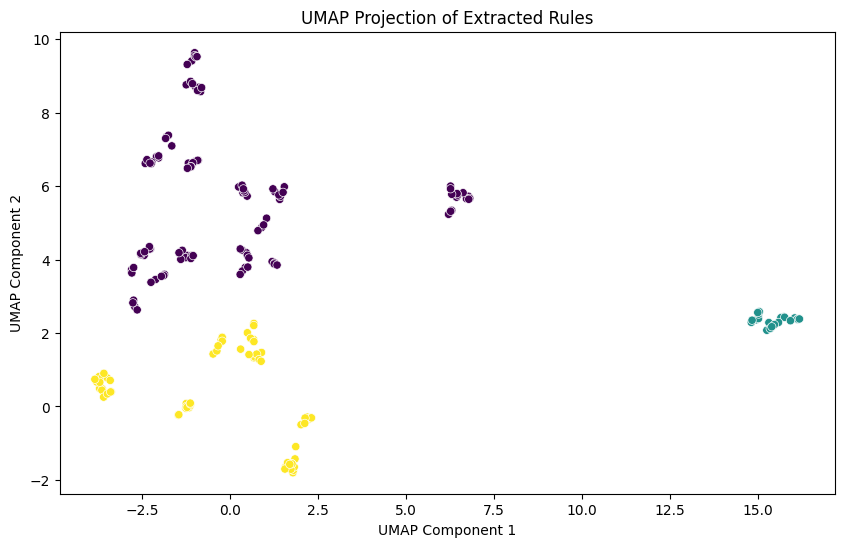

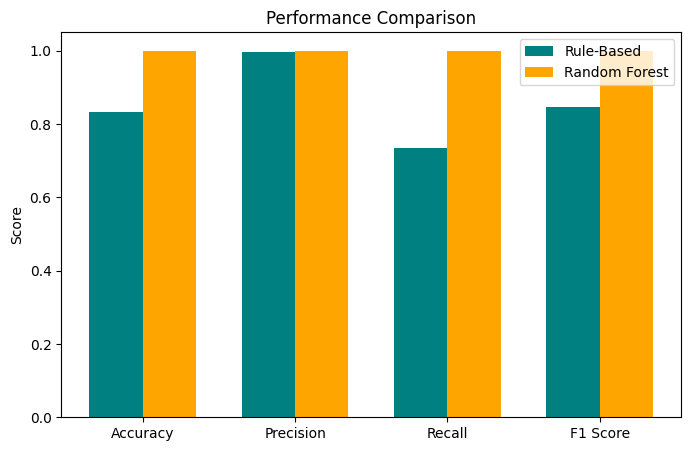

/var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/ipykernel_53441/1705964617.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tree_counts.keys()), y=list(tree_counts.values()), palette='coolwarm')


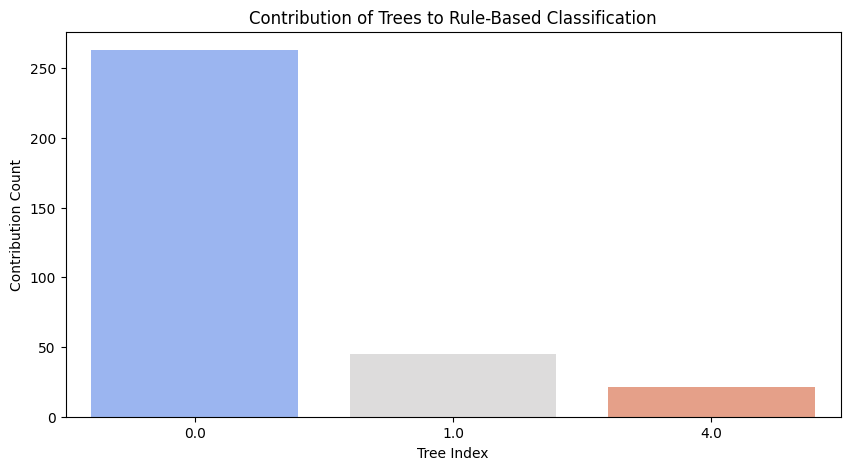

Most Dominant Rule: (worst concave points <= 0.14) AND (mean texture <= 21.31) AND (worst area <= 947.60) AND (perimeter error <= 4.03) AND (worst compactness <= 0.35)
Originating Tree: 0


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import _tree
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
feature_names = data.feature_names

# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, y)

# Extract rules from decision trees
def extract_rules(tree, feature_names):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    rules = []
    
    def recurse(node, current_rule):
        if tree_.children_left[node] == _tree.TREE_LEAF:
            rule_str = " AND ".join(current_rule)
            rules.append(rule_str)
        else:
            recurse(tree_.children_left[node], current_rule + [f"({feature_names[feature[node]]} <= {threshold[node]:.2f})"])
            recurse(tree_.children_right[node], current_rule + [f"({feature_names[feature[node]]} > {threshold[node]:.2f})"])
    
    recurse(0, [])
    return rules

# Extract and encode rules
tree_rules = [extract_rules(est, feature_names) for est in rf.estimators_]
all_rules, tree_indices = [], []
for i, rules in enumerate(tree_rules):
    for rule in rules:
        all_rules.append(rule)
        tree_indices.append(i)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
rule_vectors = vectorizer.fit_transform(all_rules)

# Dimensionality Reduction (UMAP)
reduced_vectors = umap.UMAP(n_components=2, random_state=42).fit_transform(rule_vectors.toarray())

# Clustering
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
rule_clusters = clustering.fit_predict(reduced_vectors)

# Assign global rule to each tree
tree_global_rules = {}
rule_df = pd.DataFrame({"Rule": all_rules, "Tree Index": tree_indices, "Cluster": rule_clusters})
for tree_index in range(len(tree_rules)):
    cluster_counts = Counter(rule_df[rule_df["Tree Index"] == tree_index]["Cluster"])
    if cluster_counts:
        most_common_cluster = cluster_counts.most_common(1)[0][0]
        tree_global_rules[tree_index] = rule_df[rule_df["Cluster"] == most_common_cluster]["Rule"].values[0]

# Visualize UMAP clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=rule_clusters, palette='viridis', legend=None)
plt.title("UMAP Projection of Extracted Rules")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

# Classify with summarized rules
def classify_with_summarized_rules(instance, tree_global_rules):
    votes, rule_contributions = [], {}
    for tree_idx, rule in tree_global_rules.items():
        satisfied = all(
            (float(threshold) >= instance[feature] if "<=" in condition else float(threshold) < instance[feature])
            for condition in rule.split(" AND ")
            for feature, threshold in [condition.strip("()").split(" <= " if "<=" in condition else " > ")]
        )
        votes.append(1 if satisfied else 0)
        if satisfied:
            rule_contributions[tree_idx] = rule_contributions.get(tree_idx, 0) + 1
    most_contributing_tree = max(rule_contributions, key=rule_contributions.get, default=None)
    return 1 if votes.count(1) > votes.count(0) else 0, most_contributing_tree

# Evaluate classifier
rule_predictions, rule_contributions = [], []
for _, x in X.iterrows():
    pred, tree_id = classify_with_summarized_rules(x, tree_global_rules)
    rule_predictions.append(pred)
    rule_contributions.append(tree_id)
rf_predictions = rf.predict(X)

# Performance Metrics
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

# Plot performance comparison
performance_scores = {"Rule-Based": [], "Random Forest": []}
for metric_name, metric_fn in metrics.items():
    performance_scores["Rule-Based"].append(metric_fn(y, rule_predictions))
    performance_scores["Random Forest"].append(metric_fn(y, rf_predictions))

metric_names = list(metrics.keys())
x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, performance_scores["Rule-Based"], width, label="Rule-Based", color='teal')
ax.bar(x + width/2, performance_scores["Random Forest"], width, label="Random Forest", color='orange')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
plt.title("Performance Comparison")
plt.ylabel("Score")
plt.show()

# Contribution Analysis
tree_counts = Counter(rule_contributions)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(tree_counts.keys()), y=list(tree_counts.values()), palette='coolwarm')
plt.xlabel("Tree Index")
plt.ylabel("Contribution Count")
plt.title("Contribution of Trees to Rule-Based Classification")
plt.show()

# Most dominant rule
most_dominant_tree = max(tree_counts, key=tree_counts.get, default=None)
most_dominant_rule = tree_global_rules.get(most_dominant_tree, "No dominant rule")
print(f"Most Dominant Rule: {most_dominant_rule}\nOriginating Tree: {most_dominant_tree}")


In [83]:
tree_global_rules

{0: '(worst concave points <= 0.14) AND (mean texture <= 21.31) AND (worst area <= 947.60) AND (perimeter error <= 4.03) AND (worst compactness <= 0.35)',
 1: '(worst concavity <= 0.26) AND (worst concave points <= 0.16) AND (worst area <= 1058.00) AND (worst concave points <= 0.11) AND (worst radius <= 17.02) AND (mean smoothness <= 0.10)',
 2: '(worst concave points <= 0.14) AND (mean texture <= 21.31) AND (worst area <= 947.60) AND (perimeter error <= 4.03) AND (worst compactness <= 0.35)',
 3: '(worst concavity <= 0.26) AND (worst concave points <= 0.16) AND (worst area <= 1058.00) AND (worst concave points <= 0.11) AND (worst radius <= 17.02) AND (mean smoothness <= 0.10)',
 4: '(area error <= 34.85) AND (worst perimeter <= 104.10) AND (worst symmetry <= 0.50) AND (mean area <= 532.60) AND (worst concave points <= 0.14)',
 5: '(worst concavity <= 0.26) AND (worst concave points <= 0.16) AND (worst area <= 1058.00) AND (worst concave points <= 0.11) AND (worst radius <= 17.02) AND 

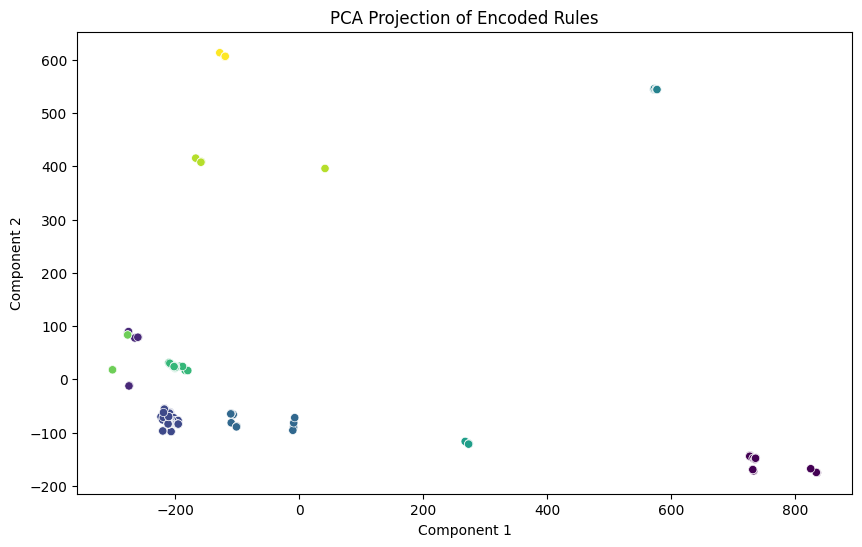

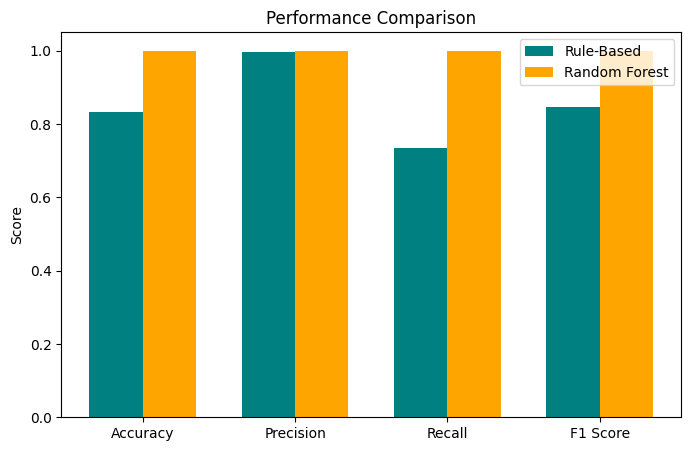

/var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/ipykernel_53441/793146013.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tree_counts.keys()), y=list(tree_counts.values()), palette='coolwarm')


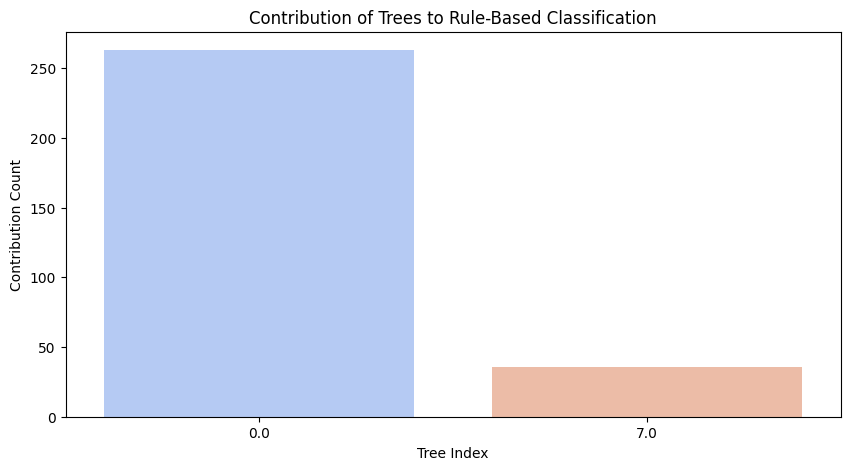

Most Dominant Rule: No dominant rule
Originating Tree: None


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import _tree
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from sklearn.impute import SimpleImputer

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
feature_names = data.feature_names

# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, y)

# Function to extract decision paths/rules
def extract_rule_paths(tree, feature_names):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    rules = []

    def recurse(node, current_rule):
        if tree_.children_left[node] == _tree.TREE_LEAF:
            rule_str = " AND ".join(current_rule)
            rules.append(rule_str)
        else:
            rule_left = f"({feature_names[feature[node]]} <= {threshold[node]:.2f})"
            current_rule.append(rule_left)
            recurse(tree_.children_left[node], current_rule)
            current_rule.pop()

            rule_right = f"({feature_names[feature[node]]} > {threshold[node]:.2f})"
            current_rule.append(rule_right)
            recurse(tree_.children_right[node], current_rule)
            current_rule.pop()

    recurse(0, [])
    return rules

# Custom rule encoder that preserves the structure
def encode_rule_structure(rules):
    encoded_rules = []
    
    # Create a label encoder for feature names (make sure to fit it first)
    feature_encoder = LabelEncoder()
    feature_encoder.fit(feature_names)  # Fit encoder on all feature names
    
    for rule in rules:
        encoded_rule = []
        
        # Split the rule into components and encode
        components = rule.split(" AND ")
        for component in components:
            # Handle the comparison operators and extract feature names
            if "<=" in component:
                feature_name, threshold = component.split(" <= ")
                feature_name = feature_name.strip("()")  # Clean up extra characters
                encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_LTE_{threshold}")
            elif ">" in component:
                feature_name, threshold = component.split(" > ")
                feature_name = feature_name.strip("()")  # Clean up extra characters
                encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_GT_{threshold}")
        
        encoded_rules.append(" AND ".join(encoded_rule))
    
    return encoded_rules

# Extract all rules from Random Forest models
all_rule_texts = []
for est in rf.estimators_:
    rules = extract_rule_paths(est, feature_names)
    all_rule_texts.extend(rules)

# Encode the rules
encoded_rules = encode_rule_structure(all_rule_texts)

# Prepare the rule vectors by extracting feature indices and threshold values
rule_vectors = []
max_length = 0  # To store the maximum length of rule vectors

# First, find the maximum length of rule vectors
for rule in encoded_rules:
    rule_vector = []
    components = rule.split(" AND ")
    for component in components:
        if "_LTE_" in component:  # Handle "<="
            feature_index, threshold = component.split("_LTE_")
            feature_index = int(feature_index.replace("FEAT_", ""))
            rule_vector.append(feature_index)  # Append feature index
            rule_vector.append(float(threshold.strip(")")))  # Append threshold as float
        elif "_GT_" in component:  # Handle ">"
            feature_index, threshold = component.split("_GT_")
            feature_index = int(feature_index.replace("FEAT_", ""))
            rule_vector.append(feature_index)  # Append feature index
            rule_vector.append(float(threshold.strip(")")))  # Append threshold as float
    
    rule_vectors.append(rule_vector)
    max_length = max(max_length, len(rule_vector))  # Update max_length

# Now, pad the rule vectors to ensure all have the same length
for i in range(len(rule_vectors)):
    # If the rule vector is shorter than the maximum length, pad with NaNs or zeros
    while len(rule_vectors[i]) < max_length:
        rule_vectors[i].append(np.nan)  # Padding with NaN

# Convert to a numpy array
rule_vectors = np.array(rule_vectors)

# Impute missing values (NaNs) before dimensionality reduction
imputer = SimpleImputer(strategy='mean')
rule_vectors_imputed = imputer.fit_transform(rule_vectors)

# Dimensionality Reduction - Choose method
reduction_method = 'PCA'  # Options: 'PCA', 'UMAP', 'TSNE'
if reduction_method == 'PCA':
    reducer = PCA(n_components=3)
elif reduction_method == 'UMAP':
    reducer = umap.UMAP(n_components=2)
elif reduction_method == 'TSNE':
    reducer = TSNE(n_components=2)
else:
    raise ValueError("Invalid reduction method")

reduced_vectors = reducer.fit_transform(rule_vectors_imputed)

# Clustering
n_clusters = 10
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
rule_clusters = clustering.fit_predict(reduced_vectors)

# Assign global rule to each tree using majority cluster
tree_global_rules = {}
rule_df = pd.DataFrame({"Rule": all_rule_texts, "Tree Index": [i for i in range(len(all_rule_texts))], "Cluster": rule_clusters})
for tree_index in range(len(rf.estimators_)):
    cluster_counts = Counter(rule_df[rule_df["Tree Index"] == tree_index]["Cluster"])
    if cluster_counts:
        most_common_cluster = cluster_counts.most_common(1)[0][0]
        rules_in_cluster = rule_df[rule_df["Cluster"] == most_common_cluster]["Rule"].values
        tree_global_rules[tree_index] = rules_in_cluster[0] if len(rules_in_cluster) > 0 else "No Rule"

# Visualize Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=rule_clusters, palette='viridis', legend=None)
plt.title(f"{reduction_method} Projection of Encoded Rules")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Classify with summarized rules
def classify_with_summarized_rules(instance, tree_global_rules):
    votes, rule_contributions = [], {}
    for tree_idx, rule in tree_global_rules.items():
        satisfied = all(
            (float(threshold) >= instance[feature] if "<=" in condition else float(threshold) < instance[feature])
            for condition in rule.split(" AND ")
            for feature, threshold in [condition.strip("()").split(" <= " if "<=" in condition else " > ")]
        )
        votes.append(1 if satisfied else 0)
        if satisfied:
            rule_contributions[tree_idx] = rule_contributions.get(tree_idx, 0) + 1
    most_contributing_tree = max(rule_contributions, key=rule_contributions.get, default=None)
    return 1 if votes.count(1) > votes.count(0) else 0, most_contributing_tree

# Evaluate classifier
rule_predictions, rule_contributions = [], []
for _, x in X.iterrows():
    pred, tree_id = classify_with_summarized_rules(x, tree_global_rules)
    rule_predictions.append(pred)
    rule_contributions.append(tree_id)
rf_predictions = rf.predict(X)

# Performance Metrics
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

# Plot performance comparison
performance_scores = {"Rule-Based": [], "Random Forest": []}
for metric_name, metric_fn in metrics.items():
    performance_scores["Rule-Based"].append(metric_fn(y, rule_predictions))
    performance_scores["Random Forest"].append(metric_fn(y, rf_predictions))

metric_names = list(metrics.keys())
x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, performance_scores["Rule-Based"], width, label="Rule-Based", color='teal')
ax.bar(x + width/2, performance_scores["Random Forest"], width, label="Random Forest", color='orange')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
plt.title("Performance Comparison")
plt.ylabel("Score")
plt.show()

# Contribution Analysis
tree_counts = Counter(rule_contributions)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(tree_counts.keys()), y=list(tree_counts.values()), palette='coolwarm')
plt.xlabel("Tree Index")
plt.ylabel("Contribution Count")
plt.title("Contribution of Trees to Rule-Based Classification")
plt.show()

# Most dominant rule
most_dominant_tree = max(tree_counts, key=tree_counts.get, default=None)
most_dominant_rule = tree_global_rules.get(most_dominant_tree, "No dominant rule")
print(f"Most Dominant Rule: {most_dominant_rule}\nOriginating Tree: {most_dominant_tree}")
